### Testy clippingu, clipping stosuje przy ujemnych krzywiznach, wartosc clippingu oraz batch size testuje eksperymentalnie

In [1]:
import os

os.chdir("..")

### Uruchamianie pojedynczego eksperymentu

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Clipping_Comparison/original_logic exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 2 eksperymentów ---

[1/2] Uruchamianie: original_logic
Epoch 24: 100%|██████████| 430/430 [00:08<00:00, 52.94it/s, v_num=ogic]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 105.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.05756024271249771
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[2/2] Uruchamianie: hybrid_clipping_logic


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 430/430 [00:08<00:00, 50.67it/s, v_num=ogic]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 113.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.94000244140625
        test_loss           0.05397620424628258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wszystkie eksperymenty zakończone ---

--- Generowanie wykresu porównawczego ---
Ostrzeżenie: Nie znaleziono logów dla original_logic, pomijam.
Ostrzeżenie: Nie znaleziono logów dla hybrid_clipping_logic, pomijam.


/tmp/ipykernel_44298/1882812167.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Wykres porównawczy zapisano w: logs/dOGR_Clipping_Comparison/comparison_plot.png


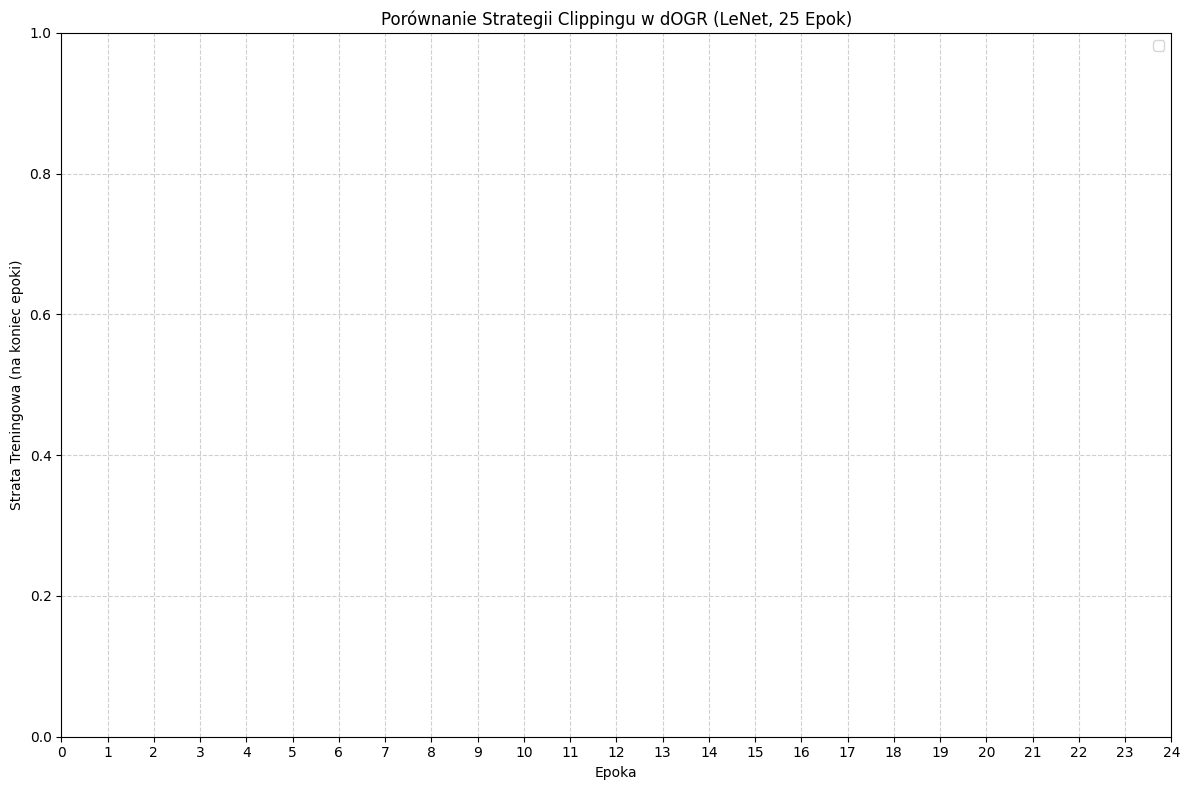

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Clipping_Comparison"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
BATCH_SIZE = 128
NET = "LeNet"

experiments = {
    "original_logic": {
        "opt": dOGR,
        "args": {"lr": 1e-3, "linear_clipping": False}
    },
    "linear_clipping_logic": {
        "opt": dOGR,
        "args": {"lr": 1e-3, "linear_clipping": True, "neg_clip_val": 10.0}
    },
}

def run_comparison():
    """Uruchamia oba zdefiniowane eksperymenty."""
    print(f"--- Uruchamianie {len(experiments)} eksperymentów ---")
    for i, (version_name, config) in enumerate(experiments.items()):
        print(f"\n[{i+1}/{len(experiments)}] Uruchamianie: {version_name}")
        
        net = net_dict[NET]()
        optimizer = config["opt"](net.parameters(), **config["args"])
        
        run(
            net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
            version=version_name, max_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE
        )
    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_comparison()


--- Generowanie wykresu porównawczego ---
Wykres porównawczy zapisano w: logs/dOGR_Clipping_Comparison/comparison_plot.png


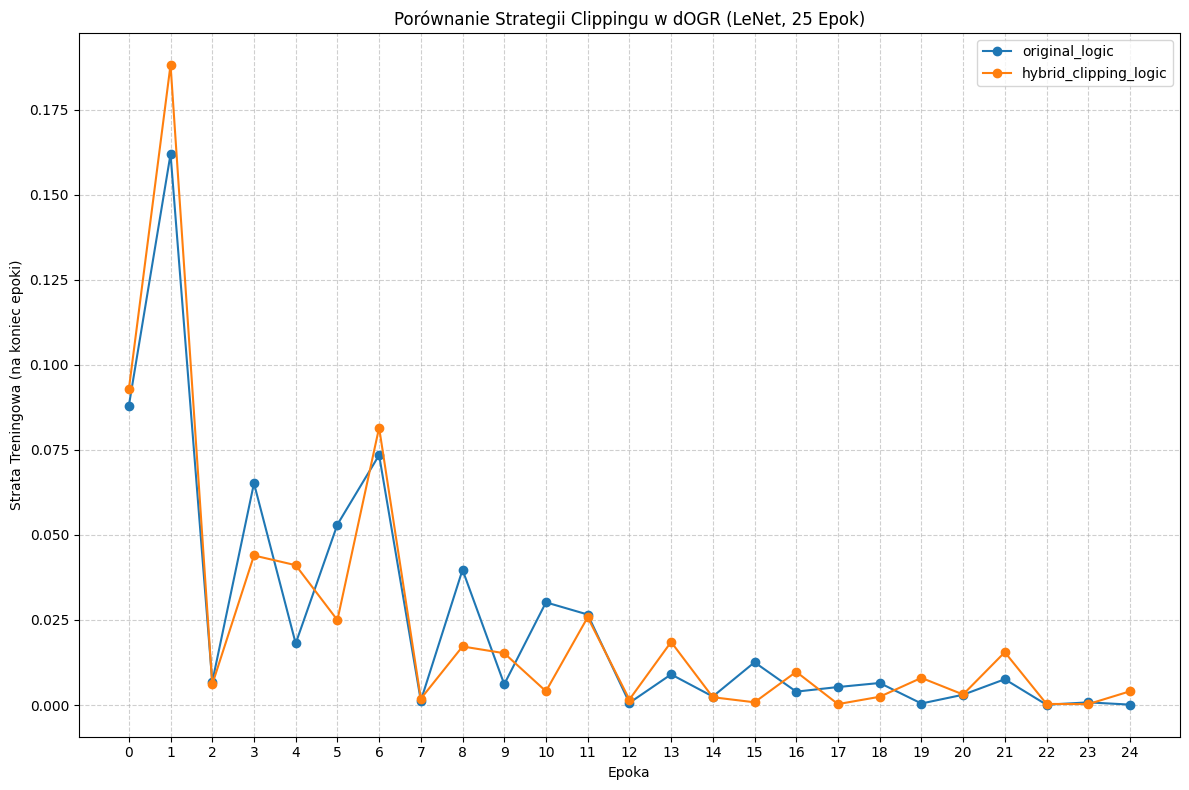

In [7]:
def plot_comparison():
    """Generuje wykres porównawczy dla obu strategii."""
    print("\n--- Generowanie wykresu porównawczego ---")
    plt.figure(figsize=(12, 8))
    
    for version_name in experiments.keys():
        path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name}" / "metrics.csv"
        if not path.exists():
            print(f"Ostrzeżenie: Nie znaleziono logów dla {version_name}, pomijam.")
            continue
            
        df = pd.read_csv(path)
        train_loss_df = df[["epoch", "train_loss"]].dropna().groupby("epoch").last().reset_index()

        plt.plot(train_loss_df["epoch"], train_loss_df["train_loss"], "o-", label=version_name)

    plt.title(f"Porównanie Strategii Clippingu w dOGR ({NET}, {MAX_EPOCHS} Epok)")
    plt.xlabel("Epoka")
    plt.ylabel("Strata Treningowa (na koniec epoki)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(range(MAX_EPOCHS))
    plt.tight_layout()
    
    plot_path = LOGGING_DIR / EXPERIMENT_NAME / "comparison_plot.png"
    plt.savefig(plot_path)
    print(f"Wykres porównawczy zapisano w: {plot_path}")
    plt.show()

if __name__ == "__main__":
    plot_comparison()

### Uruchomienie eksperymentow z siatka mozliwych parametrow clipping_val i batch_size zeby odkryc ktora kombinacja jest najlepsza

In [2]:
import os

os.chdir("..")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [1, 4, 8, 16, 32, 64],
    'neg_clip_val': np.logspace(np.log10(5), np.log10(100), 5, dtype=int).tolist() 
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
BATCH_SIZES = param_grid['batch_size']
CLIPPING_VALUES = param_grid['neg_clip_val']

experiments = []
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    experiments.append(dict(zip(keys, v)))

def run_all_experiments():
    """Uruchamia serię eksperymentów dla każdej kombinacji parametrów."""
    total_experiments = len(experiments)
    print(f"--- Uruchamianie {total_experiments} eksperymentów (Grid Search) ---")
    
    for i, config in enumerate(experiments):
        batch_size = config['batch_size']
        clip_val = config['neg_clip_val']
        
        clip_str = f"clip_{clip_val}" if clip_val is not None else "no_clip"
        version_name = f"bs_{batch_size}_{clip_str}"
        
        print(f"\n[{i+1}/{total_experiments}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        
        optimizer = dOGR(
            net.parameters(), 
            lr=LEARNING_RATE, 
            linear_clipping=True, 
            neg_clip_val=clip_val
        )
        
        try:
            run(
                net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
                version=version_name, max_epochs=MAX_EPOCHS, batch_size=batch_size
            )
        except Exception as e:
            print(f"Błąd podczas eksperymentu z config = {config}: {e}")
            print("Pominięto ten przebieg.")

    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_all_experiments()

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 5 eksperymentów (Grid Search) ---

[1/5] Uruchamianie: bs_64_clip_5



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.77it/s, v_num=ip_5]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.71it/s, v_num=ip_5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 107.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.94999694824219
        test_loss           0.08223270624876022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[2/5] Uruchamianie: bs_64_clip_10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:15<00:00, 56.09it/s, v_num=p_10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:15<00:00, 56.02it/s, v_num=p_10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 125.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.07529051601886749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[3/5] Uruchamianie: bs_64_clip_22


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 62.86it/s, v_num=p_22]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 62.79it/s, v_num=p_22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 146.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.06839779019355774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[4/5] Uruchamianie: bs_64_clip_47


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.24it/s, v_num=p_47]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.17it/s, v_num=p_47]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 126.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87000274658203
        test_loss           0.06391171365976334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[5/5] Uruchamianie: bs_64_clip_100


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.00it/s, v_num=_100]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.92it/s, v_num=_100]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 144.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.79000091552734
        test_loss           0.06443191319704056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wszystkie eksperymenty zakończone ---



--- Generowanie osobnych wykresów dla każdego batch size ---
logs/dOGR_Grid_Search/bs_1_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_100/metrics.csv
Wykres dla batch_size=1 zapisano w: logs/dOGR_Grid_Search/comparison_bs_1.png


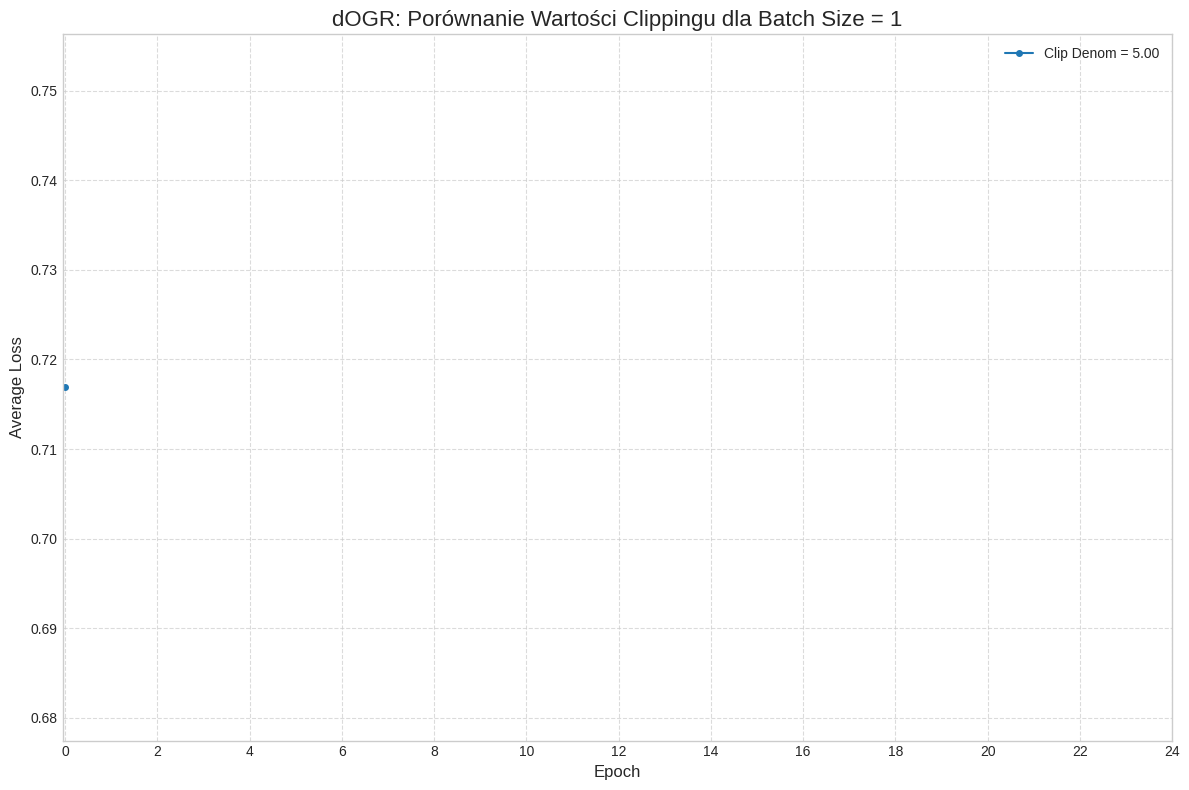

logs/dOGR_Grid_Search/bs_4_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_100/metrics.csv
Wykres dla batch_size=4 zapisano w: logs/dOGR_Grid_Search/comparison_bs_4.png


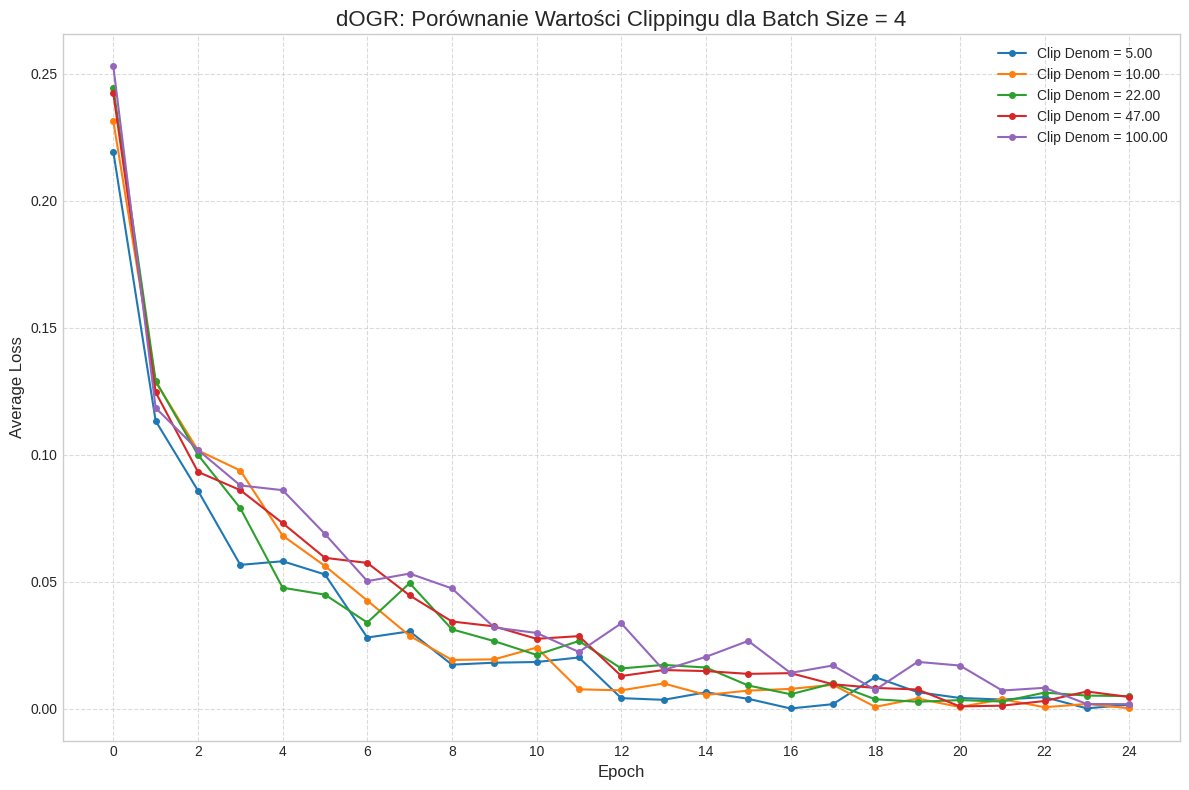

logs/dOGR_Grid_Search/bs_8_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_100/metrics.csv
Wykres dla batch_size=8 zapisano w: logs/dOGR_Grid_Search/comparison_bs_8.png


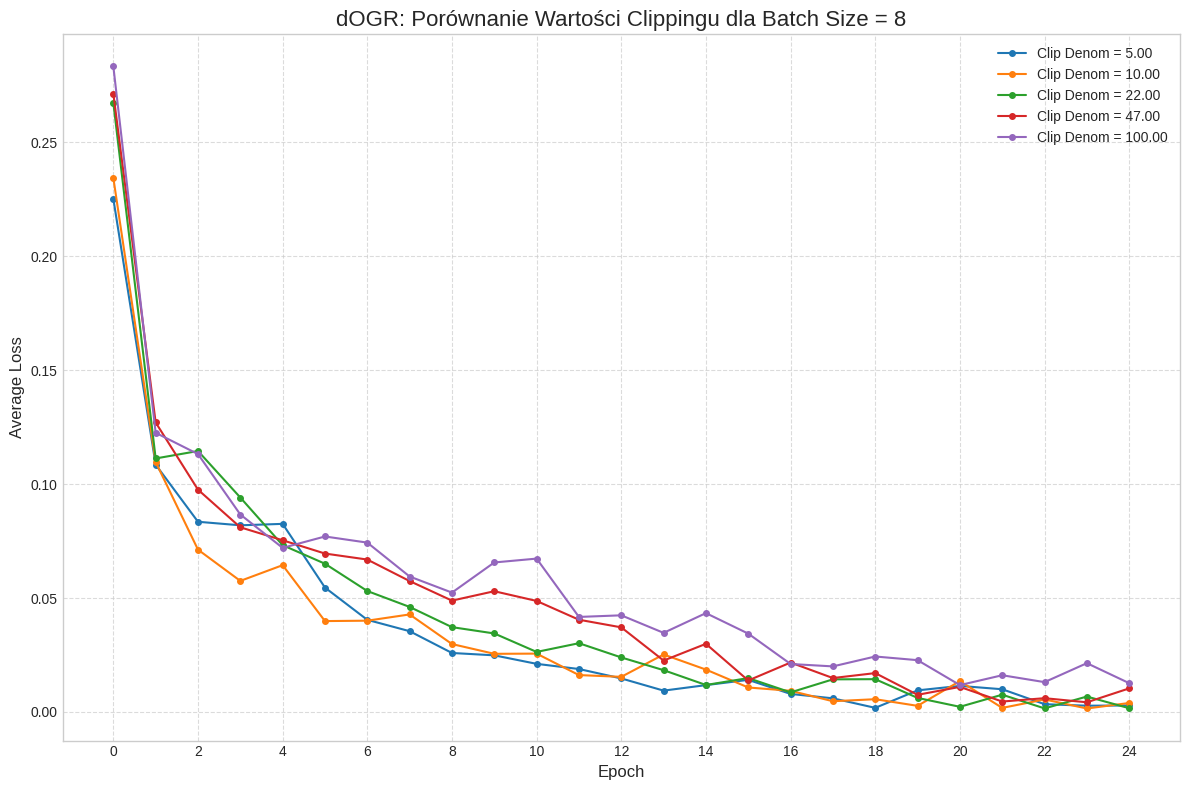

logs/dOGR_Grid_Search/bs_16_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_100/metrics.csv
Wykres dla batch_size=16 zapisano w: logs/dOGR_Grid_Search/comparison_bs_16.png


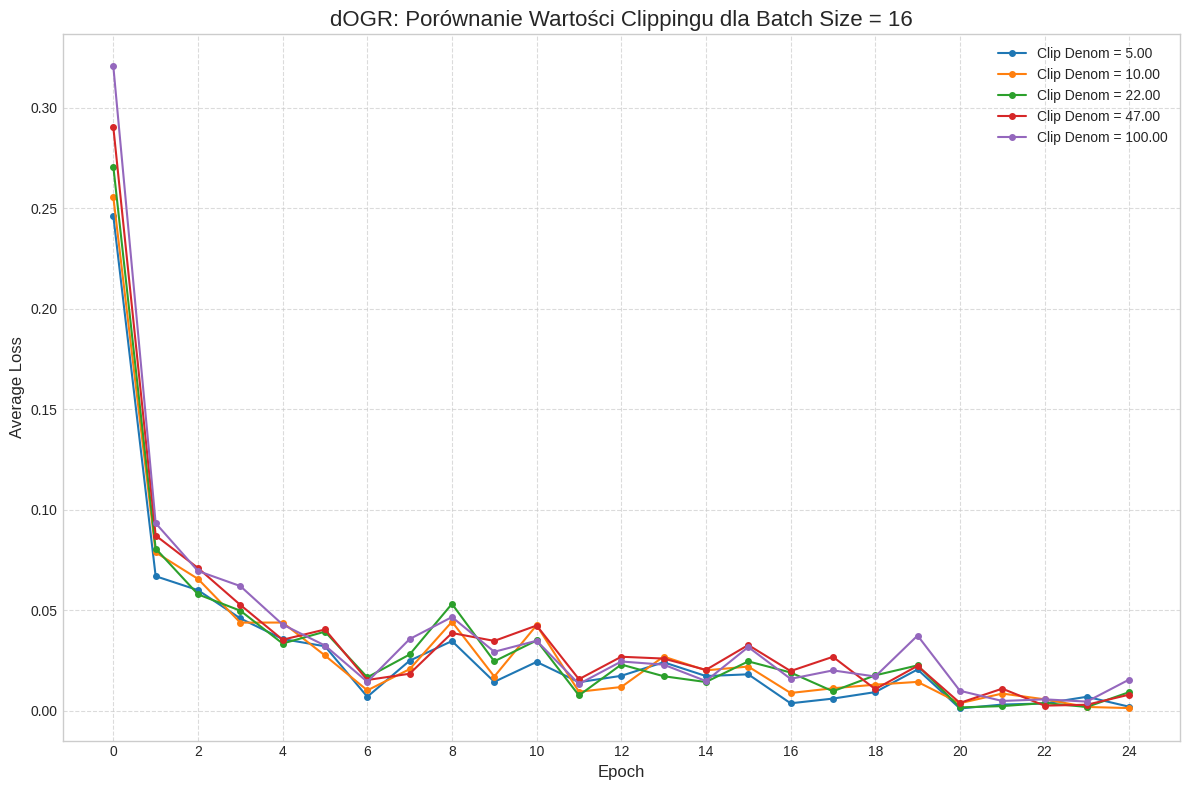

logs/dOGR_Grid_Search/bs_32_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_100/metrics.csv
Wykres dla batch_size=32 zapisano w: logs/dOGR_Grid_Search/comparison_bs_32.png


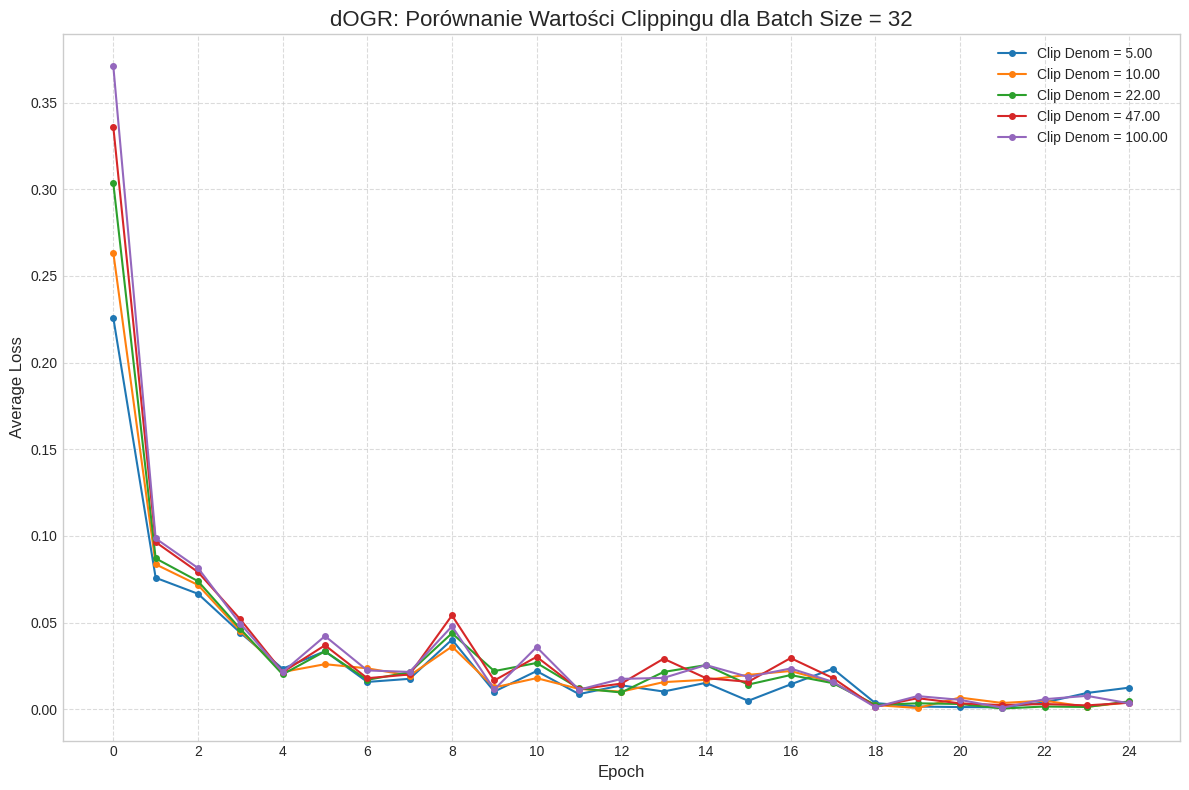

logs/dOGR_Grid_Search/bs_64_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_100/metrics.csv
Wykres dla batch_size=64 zapisano w: logs/dOGR_Grid_Search/comparison_bs_64.png


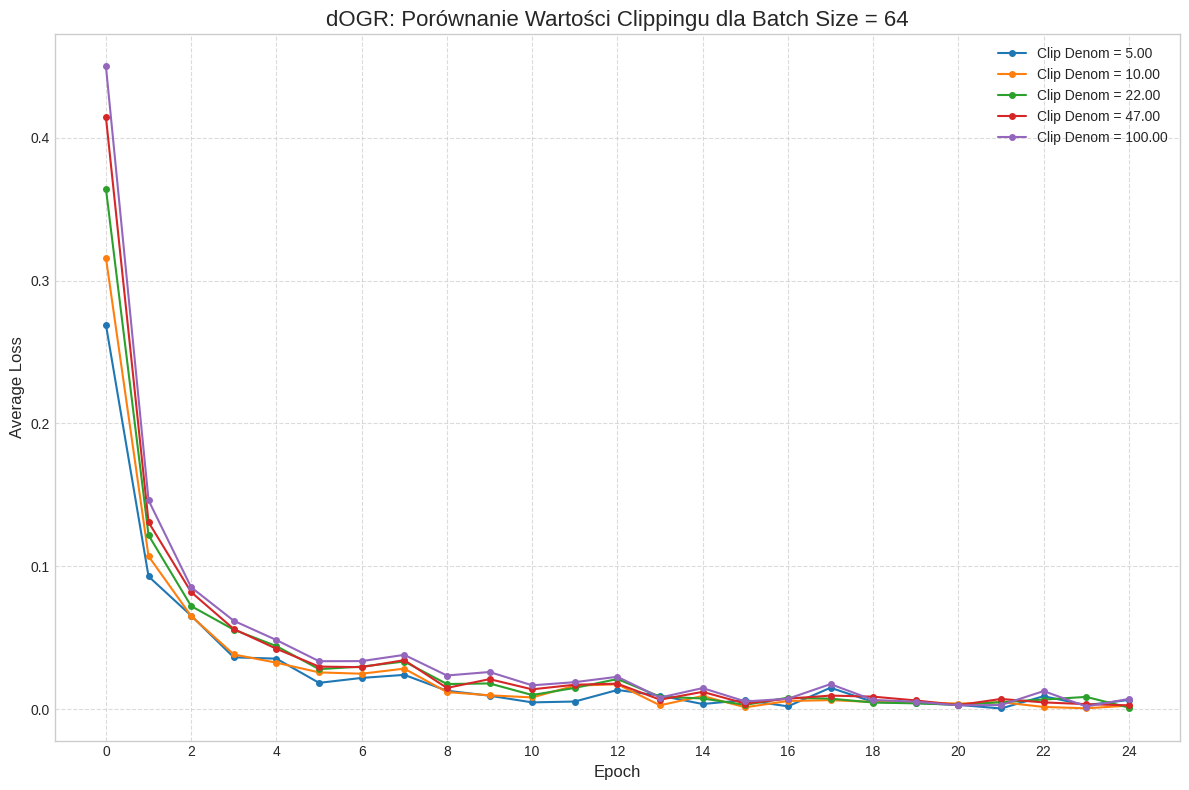

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

param_grid = {
    'batch_size': [1, 4, 8, 16, 32, 64],
    'neg_clip_val': np.logspace(np.log10(5), np.log10(100), 5, dtype=int).tolist() 
}
BATCH_SIZES = param_grid['batch_size']
CLIPPING_VALUES = param_grid['neg_clip_val']

def plot_separate_charts_by_batch_size():
    """Generuje osobny wykres porównawczy dla każdego rozmiaru paczki."""
    print("\n--- Generowanie osobnych wykresów dla każdego batch size ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    
    for batch_size in BATCH_SIZES:
        plt.figure(figsize=(12, 8))
        
        found_any_logs_for_bs = False
        for clip_val in CLIPPING_VALUES:
            version_name = f"bs_{batch_size}_clip_{clip_val}"
            path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name}" / "metrics.csv"
            print(path)
            if not path.exists():
                continue
                
            found_any_logs_for_bs = True
            df = pd.read_csv(path)
            train_loss_df = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()

            plt.plot(train_loss_df["epoch"], train_loss_df["train_loss"], "o-", label=f"Clip Denom = {clip_val:.2f}", markersize=4)

        if not found_any_logs_for_bs:
            print(f"Nie znaleziono żadnych logów dla batch_size={batch_size}, pomijam wykres.")
            plt.close() 
            continue

        plt.title(f"dOGR: Porównanie Wartości Clippingu dla Batch Size = {batch_size}", fontsize=16)
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Average Loss", fontsize=12)
        plt.legend()
        plt.grid(True, which='both', linestyle="--", alpha=0.7)
        plt.xticks(range(0, MAX_EPOCHS, 2))
        plt.tight_layout()
        
        plot_path = LOGGING_DIR / EXPERIMENT_NAME / f"comparison_bs_{batch_size}.png"
        plt.savefig(plot_path)
        print(f"Wykres dla batch_size={batch_size} zapisano w: {plot_path}")
        plt.show() 


if __name__ == "__main__":
    plot_separate_charts_by_batch_size()

In [1]:
import os

os.chdir("..")

## Testy nonlinear clippingu z dOGR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [32, 64],
    'p_norm': [0.25, 0.5, 1.0, 1.5, 2.0, 4.0, 8.0, 16.0],
    'p_eps': [0.1, 0.5, 1.0, 2.0, 5.0]
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
BATCH_SIZES = param_grid['batch_size']
P_NORM = param_grid['p_norm']

experiments = []
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    experiments.append(dict(zip(keys, v)))

def run_all_experiments():
    """Uruchamia serię eksperymentów dla każdej kombinacji parametrów."""
    total_experiments = len(experiments)
    print(f"--- Uruchamianie {total_experiments} eksperymentów (Grid Search) ---")
    
    for i, config in enumerate(experiments):
        batch_size = config['batch_size']
        p_norm = config['p_norm']
        p_eps = config['p_eps']

        p_norm_str = f"p_norm_{p_norm}" if p_norm is not None else "no_p_norm"
        p_eps_str = f"p_eps_{p_eps}" if p_eps is not None else "no_p_eps"
        version_name = f"bs_{batch_size}_{p_norm_str}_{p_eps_str}"

        print(f"\n[{i+1}/{total_experiments}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        
        optimizer = dOGR(
            net.parameters(), 
            lr=LEARNING_RATE, 
            nonlinear_clipping=True, 
            p_norm=p_norm,
            p_eps=p_eps
        )
        
        try:
            run(
                net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
                version=version_name, max_epochs=MAX_EPOCHS, batch_size=batch_size
            )
        except Exception as e:
            print(f"Błąd podczas eksperymentu z config = {config}: {e}")
            print("Pominięto ten przebieg.")

    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_all_experiments()

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 80 eksperymentów (Grid Search) ---

[1/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_0.1



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 66.81it/s, v_num=_0.1]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 66.77it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 179.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.1335555762052536
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[2/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_0.5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.41it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.38it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 177.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87000274658203
        test_loss           0.1069386750459671
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[3/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:28<00:00, 61.23it/s, v_num=_1.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:28<00:00, 61.20it/s, v_num=_1.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 176.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.08385223150253296
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[4/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_2.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.34it/s, v_num=_2.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.30it/s, v_num=_2.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 126.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.0789458155632019
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[5/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_5.0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.25it/s, v_num=_5.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.20it/s, v_num=_5.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 172.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.76000213623047
        test_loss           0.08650235086679459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[6/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_0.1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 65.97it/s, v_num=_0.1]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 65.93it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 168.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          96.61000061035156
        test_loss           0.2842804789543152
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[7/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_0.5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.40it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.36it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 171.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.79000091552734
        test_loss           0.16222597658634186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[8/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 57.87it/s, v_num=_1.0]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 57.84it/s, v_num=_1.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 154.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87999725341797
        test_loss           0.13068197667598724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[9/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_2.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 64.84it/s, v_num=_2.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 64.80it/s, v_num=_2.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 168.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.93000030517578
        test_loss           0.08869364112615585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[10/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_5.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:24<00:00, 68.96it/s, v_num=_5.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:24<00:00, 68.92it/s, v_num=_5.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 187.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.02999877929688
        test_loss           0.07983473688364029
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[11/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_0.1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.17it/s, v_num=_0.1]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.13it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 183.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                47.25
        test_loss           1.3895602226257324
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[12/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_0.5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.25it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.21it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 187.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.05999755859375
        test_loss           0.2979007661342621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[13/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.19it/s, v_num=_1.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.15it/s, v_num=_1.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 175.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.98999786376953
        test_loss           0.16536946594715118
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[14/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_2.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.14it/s, v_num=_2.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.10it/s, v_num=_2.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 174.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.19999694824219
        test_loss           0.08851232379674911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[15/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_5.0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.69it/s, v_num=_5.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.65it/s, v_num=_5.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 174.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.08320207893848419
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[16/80] Uruchamianie: bs_32_p_norm_1.5_p_eps_0.1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.27it/s, v_num=_0.1]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.22it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 175.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         30.450000762939453
        test_loss            1.761262059211731
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[17/80] Uruchamianie: bs_32_p_norm_1.5_p_eps_0.5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.16it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.11it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 170.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.44000244140625
        test_loss           0.3425016403198242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[18/80] Uruchamianie: bs_32_p_norm_1.5_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Validation DataLoader 0:  82%|████████▏ | 129/157 [00:00<00:00, 138.81it/s]

In [2]:
import os

os.chdir("..")


--- Generowanie wykresów pogrupowanych po p_norm ---
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_5.0/metrics.csv
Wykres dla p_norm=0.25 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_0.25.png


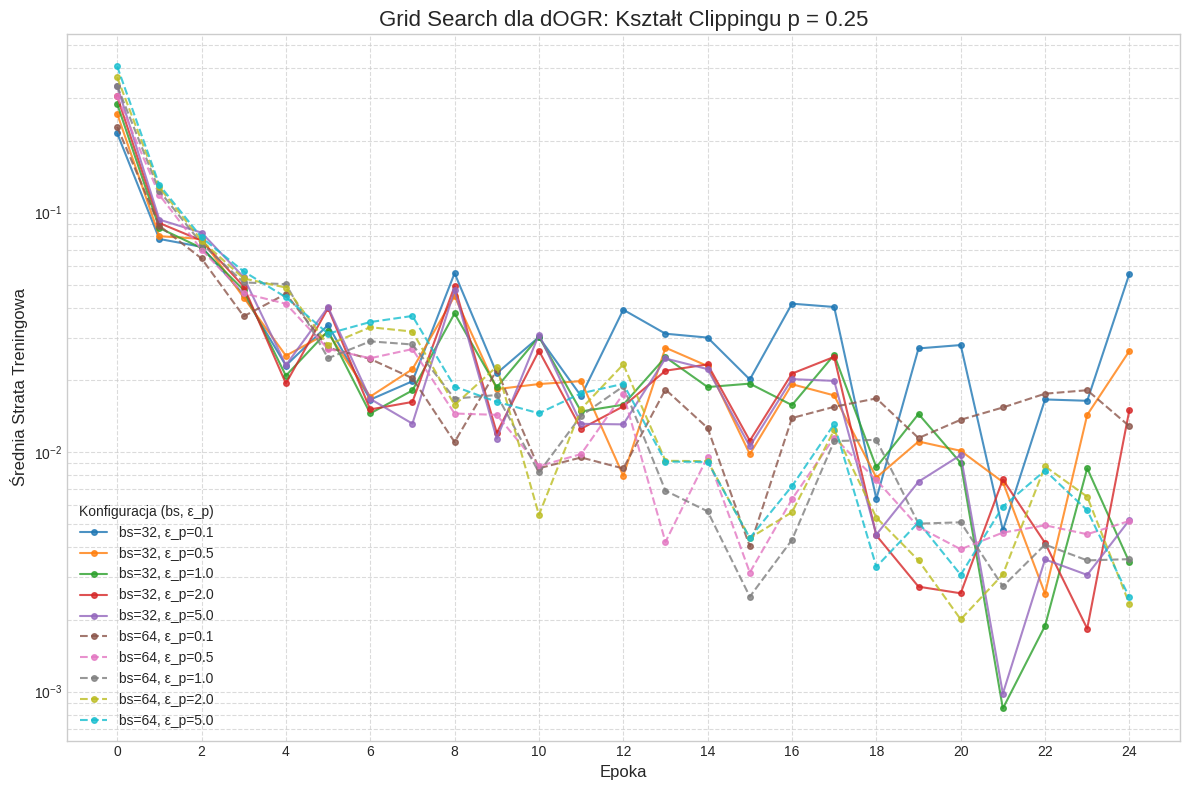

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_5.0/metrics.csv
Wykres dla p_norm=0.5 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_0.50.png


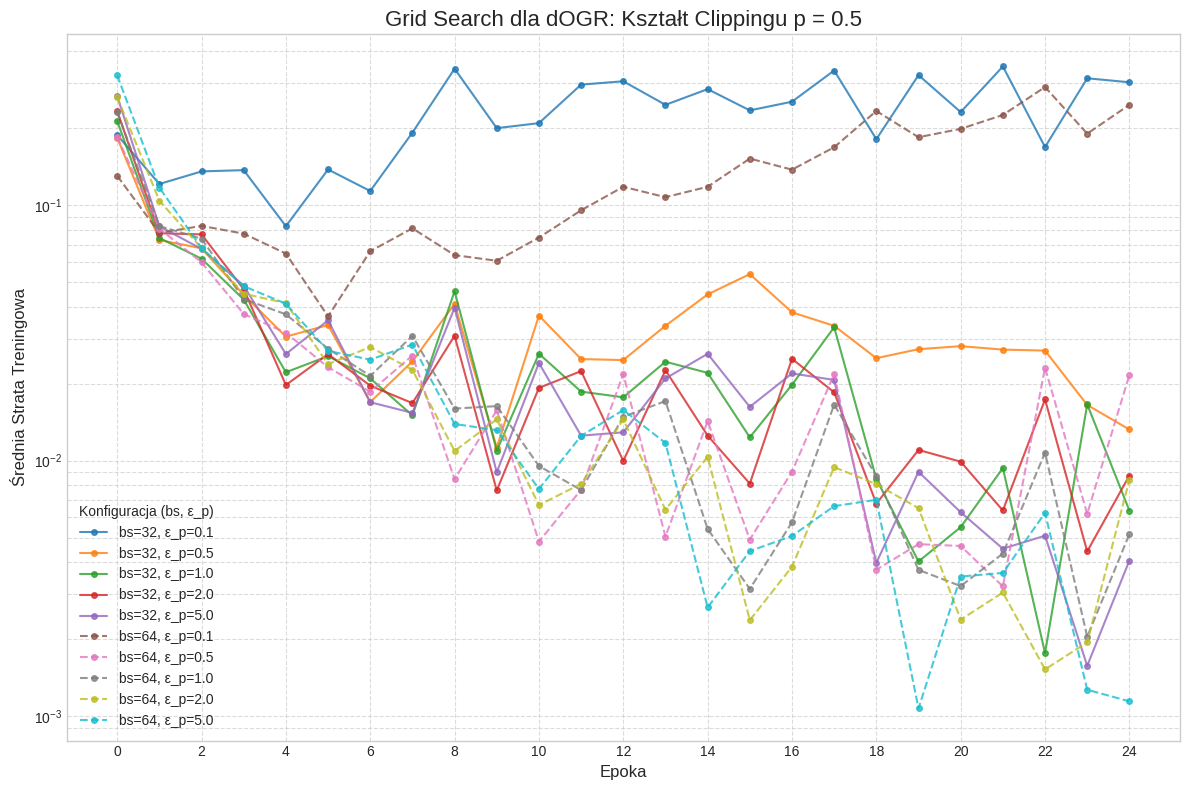

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=1.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_1.00.png


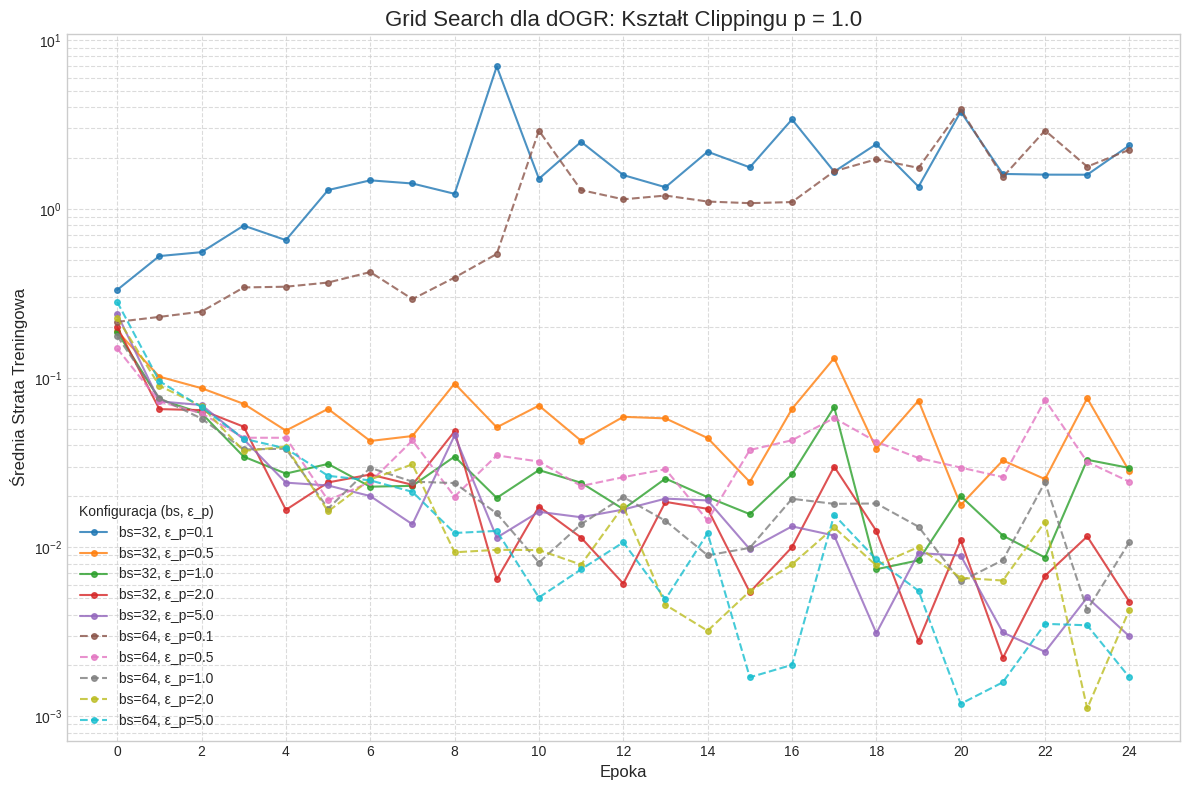

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_5.0/metrics.csv
Wykres dla p_norm=1.5 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_1.50.png


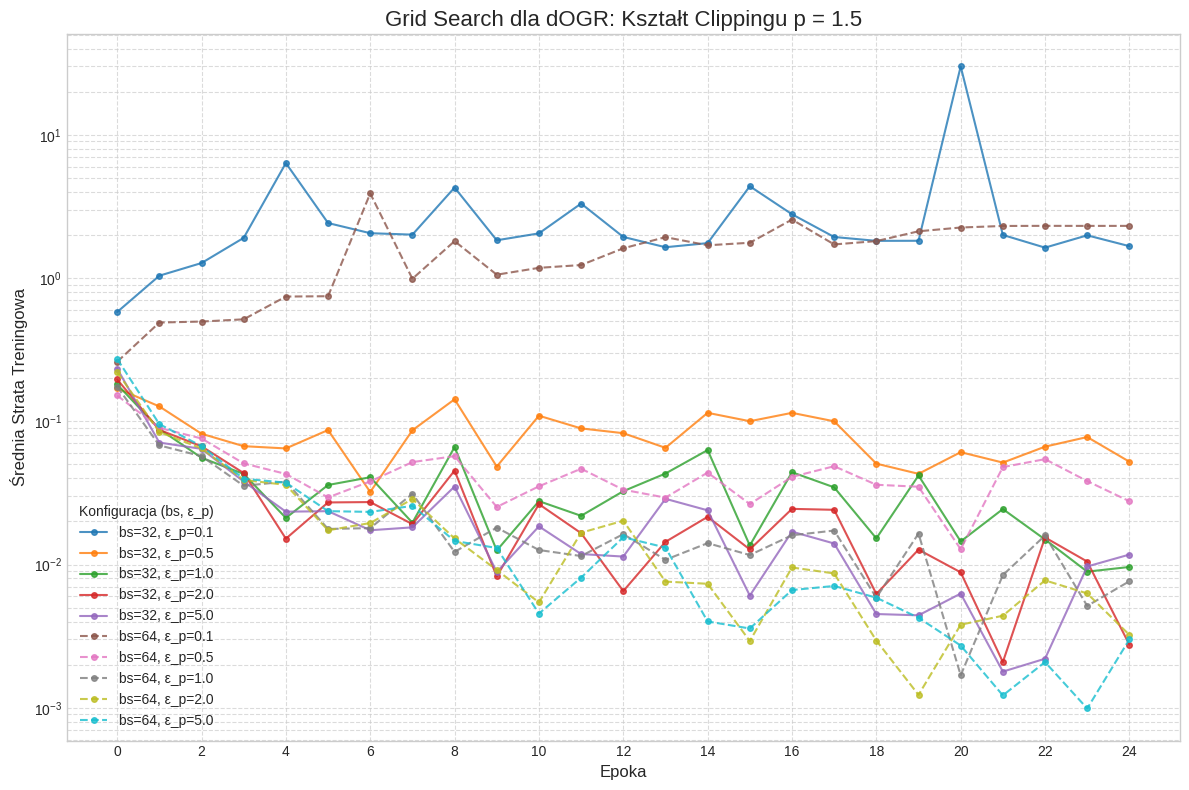

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=2.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_2.00.png


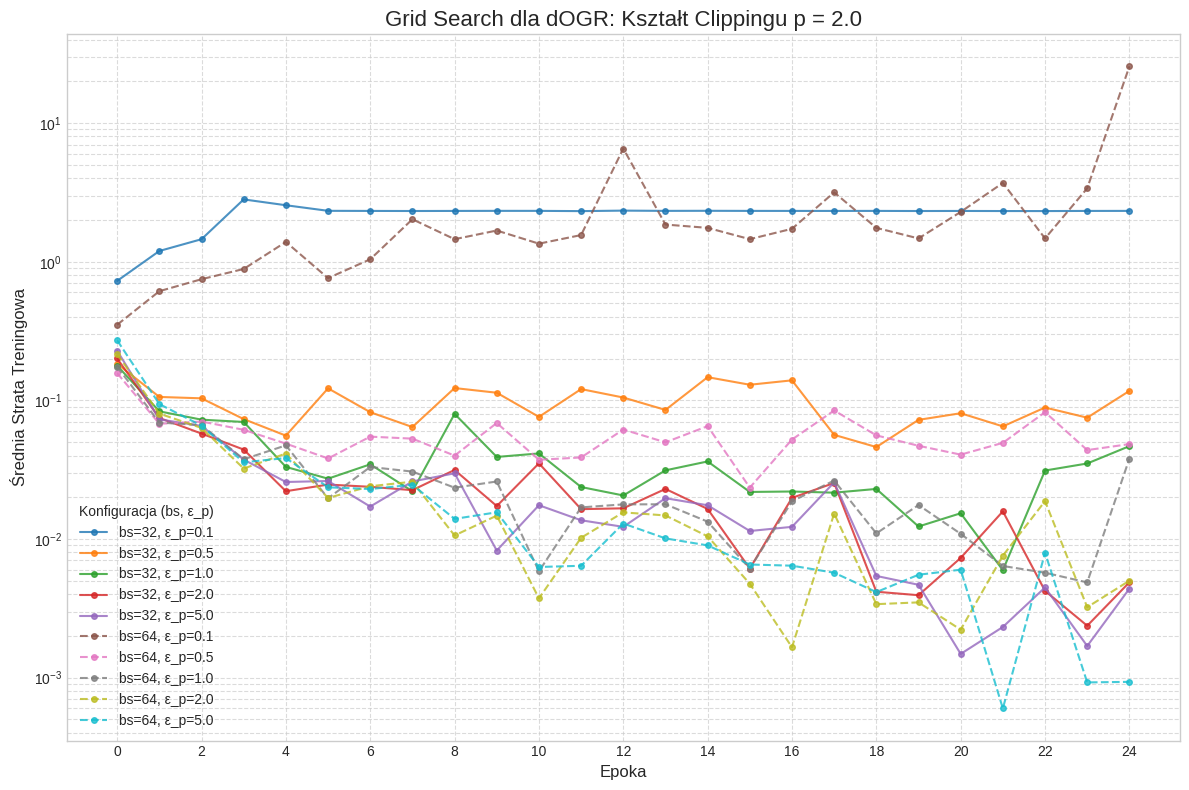

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=4.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_4.00.png


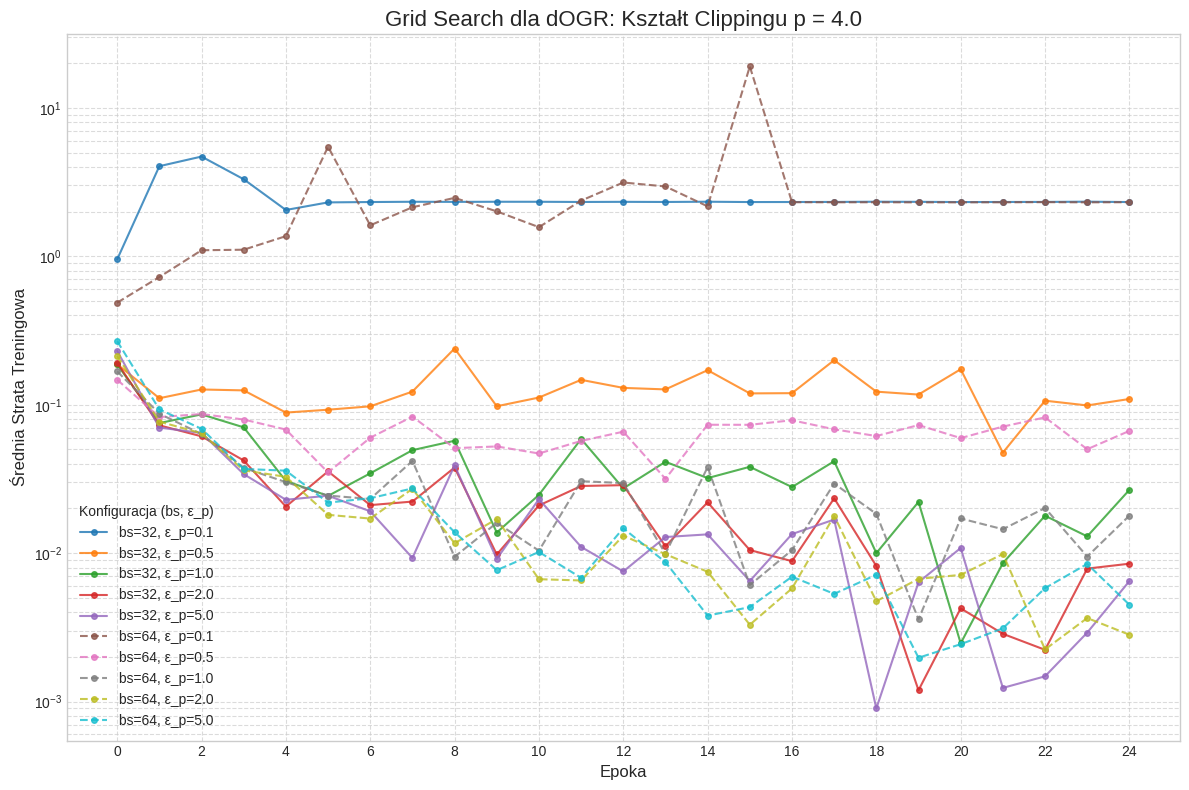

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=8.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_8.00.png


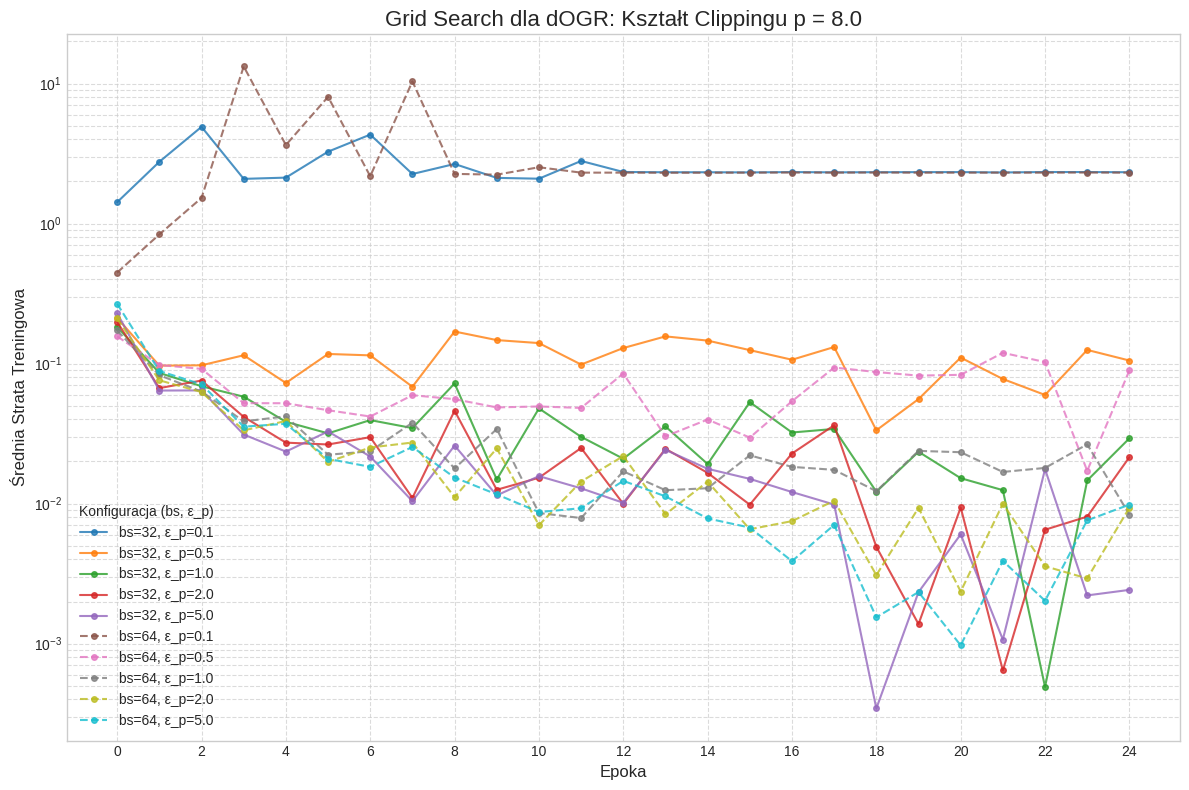

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=16.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_16.00.png


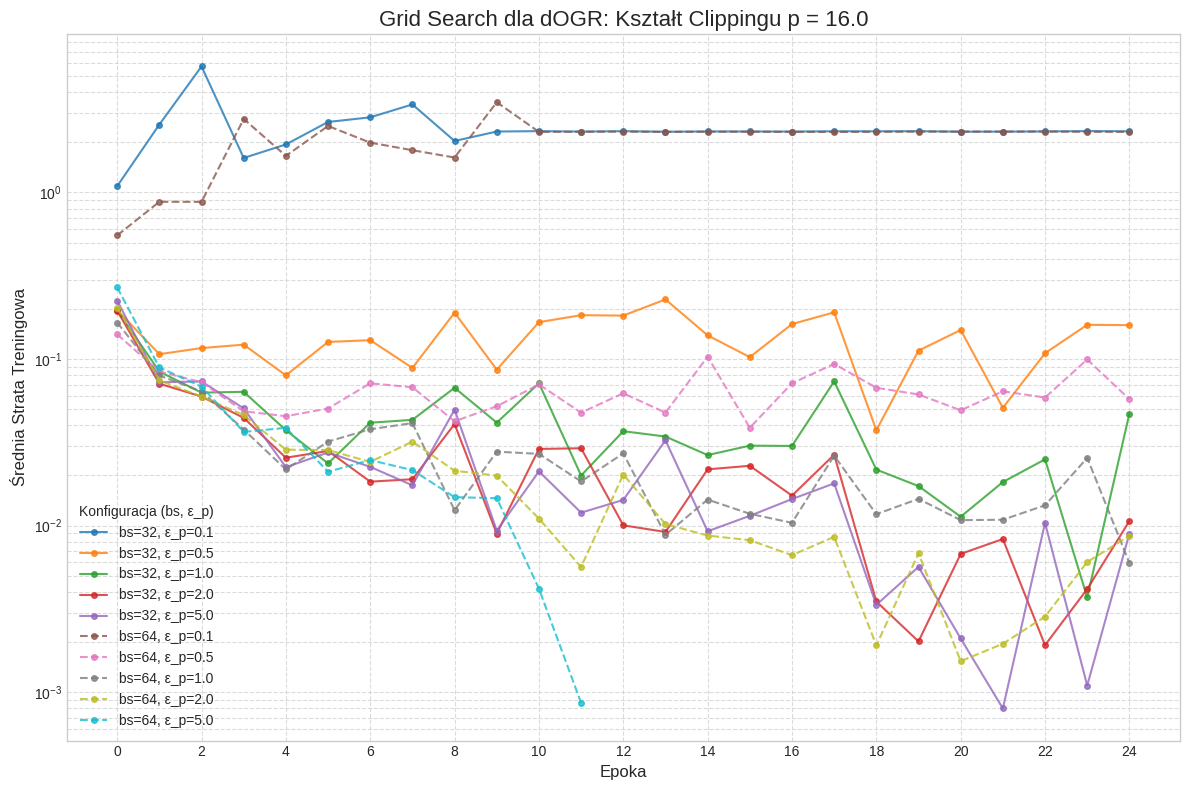

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [32, 64],
    'p_norm': [0.25, 0.5, 1.0, 1.5, 2.0, 4.0, 8.0, 16.0],
    'p_eps': [0.1, 0.5, 1.0, 2.0, 5.0]
}
BATCH_SIZES = param_grid['batch_size']
P_VALUES = param_grid['p_norm']
EPS_VALUES = param_grid['p_eps']

def plot_grouped_by_p_norm():
    print("\n--- Generowanie wykresów pogrupowanych po p_norm ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    
    for p_val in P_VALUES:
        plt.figure(figsize=(12, 8))
        
        for batch_size in BATCH_SIZES:
            for eps_p_val in EPS_VALUES:
                version_name = f"bs_{batch_size}_p_norm_{p_val}_p_eps_{eps_p_val}"
                path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name}" / "metrics.csv"
                print(path)
                
                if not path.exists():
                    continue
                
                found_any_logs_for_p_val = True
                df = pd.read_csv(path)
                train_loss_df = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()
                
                line_style = "-" if batch_size == 32 else "--"
                plt.plot(train_loss_df["epoch"], train_loss_df["train_loss"], linestyle=line_style,
                         label=f"bs={batch_size}, ε_p={eps_p_val}", marker='o', markersize=4, alpha=0.8)
                
                if not found_any_logs_for_p_val:
                    print(f"Nie znaleziono żadnych logów dla p_norm={p_val}, pomijam wykres.")
                    plt.close() 
                    continue

        plt.title(f"Grid Search dla dOGR: Kształt Clippingu p = {p_val}", fontsize=16)
        plt.xlabel("Epoka", fontsize=12)
        plt.ylabel("Średnia Strata Treningowa", fontsize=12)
        plt.legend(title="Konfiguracja (bs, ε_p)")
        plt.grid(True, which='both', linestyle="--", alpha=0.7)
        plt.xticks(range(0, MAX_EPOCHS + 1, 2))
        # plt.ylim(0, 0.4)
        plt.yscale('log')  # Ustawienie skali logarytmicznej dla osi Y
        plt.tight_layout()

        plot_path = LOGGING_DIR / EXPERIMENT_NAME / "plot_images" / f"grouped_by_p_norm_{p_val:.2f}.png"
        plt.savefig(plot_path)
        print(f"Wykres dla p_norm={p_val} zapisano w: {plot_path}")
        plt.show()

if __name__ == "__main__":
    plot_grouped_by_p_norm()

## Testy nonlinear clipping dOGR, tuning parametrow p_norm, p_eps, beta, trust_factor

In [2]:
import os

os.chdir("..")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [64],
    # 4 punkty liniowo rozłożone w najbardziej obiecującym zakresie od 0.1 do 0.5
    'p_norm': np.linspace(0.1, 0.5, 10).tolist(),
    # 4 punkty logarytmicznie rozłożone w stabilnym zakresie od 1.0 do 10.0
    'p_eps': np.logspace(np.log10(5.0), np.log10(50.0), 10).tolist(),
    # 2 punkty: 0.5 i 0.9
    'beta': np.linspace(0.1, 0.9, 8).tolist(),
    # 2 punkty: 0.5 i 1.0
    'trust_factor': np.linspace(0.1, 1.0, 8).tolist()
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
BATCH_SIZES = param_grid['batch_size']
P_VALUES = param_grid['p_norm']
EPS_VALUES = param_grid['p_eps']
BETA = param_grid['beta']
TRUST_FACTOR = param_grid['trust_factor']

experiments = []
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    experiments.append(dict(zip(keys, v)))

def run_all_experiments():
    """Uruchamia serię eksperymentów dla każdej kombinacji parametrów."""
    total_experiments = len(experiments)
    print(f"--- Uruchamianie {total_experiments} eksperymentów (Grid Search) ---")
    
    for i, config in enumerate(experiments):
        batch_size = config['batch_size']
        p_norm = config['p_norm']
        p_eps = config['p_eps']
        beta = config['beta']
        trust_factor = config['trust_factor']

        p_norm_str = f"p_norm_{p_norm:.2f}" if p_norm is not None else "no_p_norm"
        p_eps_str = f"p_eps_{p_eps:.2f}" if p_eps is not None else "no_p_eps"
        beta_str = f"beta_{beta:.2f}" if beta is not None else "no_beta"
        trust_factor_str = f"trust_factor_{trust_factor:.2f}" if trust_factor is not None else "no_trust_factor"
        version_name = f"bs_{batch_size}_{p_norm_str}_{p_eps_str}_{beta_str}_{trust_factor_str}"

        print(f"\n[{i+1}/{total_experiments}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        
        optimizer = dOGR(
            net.parameters(), 
            lr=LEARNING_RATE, 
            nonlinear_clipping=True, 
            p_norm=p_norm,
            p_eps=p_eps,
            beta=beta,
            trust_factor=trust_factor
        )
        
        try:
            run(
                net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
                version=version_name, max_epochs=MAX_EPOCHS, batch_size=batch_size
            )
        except Exception as e:
            print(f"Błąd podczas eksperymentu z config = {config}: {e}")
            print("Pominięto ten przebieg.")

    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_all_experiments()

In module products __package__, __name__ == tests tests.main
